In [5]:
%matplotlib inline
import os
import re
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

In [6]:
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

In [7]:
def is_binary(series, allow_na=False):
    if allow_na:
        series.dropna(inplace=True)
    return sorted(series.unique()) == [0, 1]

In [8]:
RE_EMAIL = re.compile(
    r"(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*|(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*)@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])")
RE_URL = re.compile(r"((https?|ftp|smtp):\/\/)?(www.)?[a-z0-9]+\.[a-z]+(\/[a-zA-Z0-9#]+\/?)*")
RE_RELAX_PHONE = re.compile('(\(? ?[\d]{2,3} ?\)?.{,3}?){2,}')
# Taken from:
# http://www.cs.cmu.edu/~vitor/papers/sigFilePaper_finalversion.pdf
# Line matches the regular expression "^[\s]*---*[\s]*$".
RE_SEPARATOR = re.compile('^[\s]*---*[\s]*')
RE_REPLY = re.compile('^\>')
RE_REPLY_PUNCT = re.compile('^[^A-Za-z0-9]{1,2}\>')
RE_TAB = re.compile('\t')
RE_WROTE = re.compile('\s(wr[oi]tes?:)$')

# Taken from:
# http://www.cs.cmu.edu/~vitor/papers/sigFilePaper_finalversion.pdf
# Line has a sequence of 10 or more special characters.
RE_SPECIAL_CHARS = re.compile(('^[\s]*([\*]|#|[\+]|[\^]|-|[\~]|[\&]|[\$]|_|[\!]|'
                               '[\/]|[\%]|[\:]|[\=]){10,}[\s]*$'))

RE_SIGNATURE_WORDS = re.compile(('(T|t)hank.*,|(B|b)est|(R|r)egards|'
                                 '^sent[ ]{1}from[ ]{1}my[\s,!\w]*$|BR|(S|s)incerely|'
                                 '(C|c)orporation|Group'))

# Taken from:
# http://www.cs.cmu.edu/~vitor/papers/sigFilePaper_finalversion.pdf
# Line contains a pattern like Vitor R. Carvalho or William W. Cohen.
RE_NAME = re.compile('[A-Z][a-z]+\s\s?[A-Z][\.]?\s\s?[A-Z][a-z]+')


def punct_percent(line):
    if len(line) == 0:
        return 0
    punct = [c for c in line if c in string.punctuation]
    return len(punct) / len(line)


def alphanum_percent(line):
    if len(line) == 0:
        return 0
    punct = [c for c in line if c.isalnum()]
    return len(punct) / len(line)

In [9]:
feature_dict = {
        'email': lambda doc: 1 if RE_EMAIL.search(doc[0]) else 0,
        'url': lambda doc: 1 if RE_URL.search(doc[0]) else 0,
        'phone': lambda doc: 1 if RE_RELAX_PHONE.search(doc[0]) else 0,
        'sigdelimiter': lambda doc: 1 if RE_SEPARATOR.match(doc[0]) else 0,
        'special': lambda doc: 1 if RE_SPECIAL_CHARS.search(doc[0]) else 0,
        'words': lambda doc: 1 if RE_SIGNATURE_WORDS.search(doc[0]) else 0,
        'name': lambda doc: 1 if RE_NAME.search(doc[0]) else 0,
        'endquote': lambda doc: 1 if doc[0].endswith("\"") else 0,
        'tabs1': lambda doc: 1 if len(RE_TAB.findall(doc[0])) == 1 else 0,
        'tabs2': lambda doc: 1 if len(RE_TAB.findall(doc[0])) == 2 else 0,
        'tabs3': lambda doc: 1 if len(RE_TAB.findall(doc[0])) >= 3 else 0,
        'punct20': lambda doc: 1 if punct_percent(doc[0]) >= 0.2 else 0,
        'punct50': lambda doc: 1 if punct_percent(doc[0]) >= 0.5 else 0,
        'punct90': lambda doc: 1 if punct_percent(doc[0]) >= 0.9 else 0,
        'reply': lambda doc: 1 if RE_REPLY.match(doc[0]) else 0,
        'startpunct': lambda doc: 1 if doc[0].startswith(tuple(p for p in string.punctuation)) else 0,
        'firstchar': lambda doc: doc[0][0] if len(doc[0]) > 0 else "",
        'replypunct': lambda doc: 1 if RE_REPLY_PUNCT.match(doc[0]) else 0,
        'wrote': lambda doc: 1 if RE_WROTE.search(doc[0]) else 1,
        'alphanum90': lambda doc: 1 if alphanum_percent(doc[0]) < 0.9 else 0,
        'alphanum50': lambda doc: 1 if alphanum_percent(doc[0]) < 0.5 else 0,
        'alphanum10': lambda doc: 1 if alphanum_percent(doc[0]) < 0.1 else 0,
        'title': lambda doc: 1 if doc[0].strip().istitle() else 0
    }

In [24]:
ENTITY_PATTERN = "^#sig#"
def line_to_entity(line, filename, i):
    m = re.match(ENTITY_PATTERN, line)
    if m:
        e = {
            "line": line[5:],
            "filename": filename,
            "entity": "signature",
            "len": len(line[5:]),
            "lineNo": i+1
        }
    else:
        e = {"line": line, "filename": filename, "entity": "no_entity", "len": len(line), "lineNo": i+1}    
    doc = tuple((e["line"],))
    for feature, fn in feature_dict.items():            
        e[feature] = fn(doc)    
    return e

In [11]:
def remove_blanks(lines):    
    return [line for line in lines if len(line.strip()) > 0]

In [17]:
def get_signature_length(ents):
    """ Signature length in number of lines """
    return sum(1 for e in ents if e["entity"] == "signature")

In [12]:
files_path = r"F:\Documents\stopansko\masters\thesis\data\clean"
filenames = [f for f in os.listdir(files_path) if os.path.isfile(os.path.join(files_path, f))]

In [25]:
files = list()
entities = list()
for filename in filenames:
    with open(os.path.join(files_path, filename), mode="r", encoding="utf-8") as f:
        lines = f.read().splitlines()
        non_blanks = remove_blanks(lines)
        if len(non_blanks) > 0:
            lengths = [len(line) for line in non_blanks]
            file_entities = [line_to_entity(line, filename, i) for i, line in enumerate(non_blanks)]
            entities.extend(file_entities)
            files.append({
                "filename": filename,
                "nlines": len(lines),
                "len_avg": np.ceil(np.mean(lengths)),
                "len_min": min(lengths),
                "len_max": max(lengths),
                "nBlanks": len(lines) - len(non_blanks),
                "nNonBlanks": len(non_blanks),
                "nSig": get_signature_length(file_entities)
            })
        
df_files = pd.DataFrame(files) 
entities = pd.DataFrame(entities)

In [26]:
master = entities.merge(df_files, on="filename")

In [27]:
master.iloc[100:110,]

,line,filename,entity,len,lineNo,email,url,phone,sigdelimiter,special,...,alphanum50,alphanum10,title,nlines,len_avg,len_min,len_max,nBlanks,nNonBlanks,nSig
100,lisa,111.txt,signature,4,3,0,0,0,0,0,...,0,0,0,6,24.0,7,56,3,3,1
101,"Lisa,",112.txt,no_entity,5,1,0,0,0,0,0,...,0,0,1,6,36.0,5,90,3,3,1
102,\tDO you need the detail the Enron has for Haf...,112.txt,no_entity,90,2,0,0,0,0,0,...,0,0,0,6,36.0,5,90,3,3,1
103,Ka'Tina,112.txt,signature,7,3,0,0,0,0,0,...,0,0,1,6,36.0,5,90,3,3,1
104,\tjohn.lavorato@enron.com,113.txt,no_entity,24,1,1,1,0,0,0,...,0,0,0,12,113.0,10,528,5,7,2
105,\tkathy.reeves@enron.com,113.txt,no_entity,23,2,1,1,0,0,0,...,0,0,0,12,113.0,10,528,5,7,2
106,\tkathy.reeves@enron.com,113.txt,no_entity,23,3,1,1,0,0,0,...,0,0,0,12,113.0,10,528,5,7,2
107,"My apologies if this has been done, but I'm in...",113.txt,no_entity,170,4,0,0,0,0,0,...,0,0,0,12,113.0,10,528,5,7,2
108,I'm interested in getting the greatest granula...,113.txt,no_entity,528,5,0,1,0,0,0,...,0,0,0,12,113.0,10,528,5,7,2
109,"Thanks,",113.txt,signature,7,6,0,0,0,0,0,...,0,0,1,12,113.0,10,528,5,7,2


In [28]:
master.dtypes

line             object
filename         object
entity           object
len               int64
lineNo            int64
email             int64
url               int64
phone             int64
sigdelimiter      int64
special           int64
words             int64
name              int64
endquote          int64
tabs1             int64
tabs2             int64
tabs3             int64
punct20           int64
punct50           int64
punct90           int64
reply             int64
startpunct        int64
firstchar        object
replypunct        int64
wrote             int64
alphanum90        int64
alphanum50        int64
alphanum10        int64
title             int64
nlines            int64
len_avg         float64
len_min           int64
len_max           int64
nBlanks           int64
nNonBlanks        int64
nSig              int64
dtype: object

In [29]:
master["posFromEnd"] = master.nNonBlanks - master.lineNo
master["last"] = master.posFromEnd.apply(lambda x: 1 if x == 0 else 0)
master["prevlast"] = master.posFromEnd.apply(lambda x: 1 if x == 1 else 0)
master["last5"] = master.posFromEnd.apply(lambda x: 1 if x < 5 else 0)
master["last11"] = master.posFromEnd.apply(lambda x: 1 if x < 11 else 0)
master["posRatio"] = master.lineNo / master.nlines # 1 = last
master["posRatioNB"] = master.lineNo / master.nNonBlanks # 1 = last
master["lenRatio"] = master.len / master.len_avg

master["less_avg_len"] = master.apply(lambda row: 1 if row.len <= row.len_avg else 0, axis=1)
master["more_avg_len"] = master.apply(lambda row: 1 if row.len > row.len_avg else 0, axis=1)
master["less_avg_len75"] = master.apply(lambda row: 1 if row.len <= (row.len_avg*.75) else 0, axis=1)
master["less_avg_len50"] = master.apply(lambda row: 1 if row.len <= (row.len_avg*.5) else 0, axis=1)

In [30]:
master.loc[0:12:,("line", "posFromEnd", "last", "prevlast", "last5", "last11", "posRatio", "posRatioNB", "len", "len_avg", "lenRatio")]

,line,posFromEnd,last,prevlast,last5,last11,posRatio,posRatioNB,len,len_avg,lenRatio
0,"Lisa,",2,0,0,1,1,0.142857,0.333333,5,85.0,0.058824
1,I apologize for the delay! This is a new one ...,1,0,1,1,1,0.285714,0.666667,239,85.0,2.811765
2,Rhonda,0,1,0,1,1,0.428571,1.000000,6,85.0,0.070588
3,"Hi Rhonda,",5,0,0,0,1,0.090909,0.166667,10,232.0,0.043103
4,I know you are not the one who is working on ...,4,0,0,1,1,0.181818,0.333333,395,232.0,1.702586
5,lisa,3,0,0,1,1,0.272727,0.500000,4,232.0,0.017241
6,**********************************************...,2,0,0,1,1,0.363636,0.666667,70,232.0,0.301724
7,This e-mail is the property of Enron Corp. and...,1,0,1,1,1,0.454545,0.833333,818,232.0,3.525862
8,**********************************************...,0,1,0,1,1,0.545455,1.000000,70,232.0,0.301724
9,"Leo/Monika,",2,0,0,1,1,0.142857,0.333333,11,29.0,0.379310


In [31]:
master.sample(10).loc[:,("len", "len_avg", "less_avg_len", "more_avg_len", "line", "hasCid")]

G:\Programs\Anaconda2\envs\thesis-enron\lib\site-packages\pandas\core\indexing.py:805: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_lowerdim(tup)


,len,len_avg,less_avg_len,more_avg_len,line,hasCid
69,244,109.0,0,1,This e-mail communication is confidential and ...,NaN
1651,52,49.0,0,1,two of an expansion project at its Horizon Pul...,NaN
2492,818,232.0,0,1,This e-mail is the property of Enron Corp. and...,NaN
1304,9,42.0,1,0,"Jennifer,",NaN
2679,76,66.0,0,1,d. I have vetted my list against Blakes' mast...,NaN
1547,14,50.0,1,0,(403) 233-4686,NaN
1357,226,76.0,0,1,Now that there is a more concerted investigati...,NaN
2396,40,42.0,1,0,The happiest of people don't necessarily,NaN
2369,34,42.0,1,0,that we don't know what we've been,NaN
791,77,51.0,0,1,If you would like someone else to receive this...,NaN


In [32]:
all_features = feature_dict.keys() | ["last", "prevlast", "last5", "last11"]

In [33]:
signatures = master[master.entity == "signature"]

# Where are the signatures in the text?

In [34]:
# Median file length
print(f"Median file length: {np.median(master.nNonBlanks)}")
print(f"Average file length: {np.mean(master.nNonBlanks)}")

# Signature length in number of lines
print(f"Median signature length: {master.nSig.median()} lines")
print(f"Mean signature length: {master.nSig.mean()} lines")

Median file length: 26.0
Average file length: 57.71138845553822
Median signature length: 2.0 lines
Mean signature length: 4.002808112324493 lines


In [35]:
master.nSig.median() / master.nlines.median() # the median signature is 15% of the median file (all lines)

0.05128205128205128

In [36]:
master.nSig.median() / master.nNonBlanks.median() # the median signature is 44% of the median file (non-blank lines)

0.07692307692307693

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DAA8DBEE88>]],
      dtype=object)

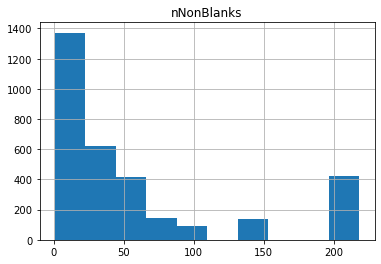

In [37]:
master.hist(column="nNonBlanks")

In [38]:
noreplies = master[~master.line.str.startswith(">")]

In [39]:
# Median file length without replies
print(f"Median file length: {np.median(noreplies.nNonBlanks)}")
print(f"Average file length: {np.mean(noreplies.nNonBlanks)}")

Median file length: 26.0
Average file length: 57.97857592942659


In [40]:
# Line No of signatures
print(f"Median lineNo: {np.median(signatures.lineNo)}")
print(f"Average lineNo: {np.mean(signatures.lineNo)}")

Median lineNo: 9.0
Average lineNo: 20.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DAA8E36D08>]],
      dtype=object)

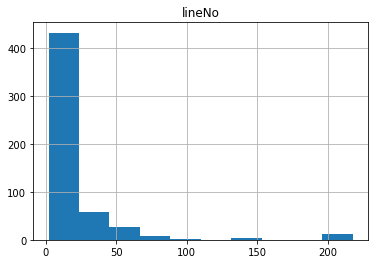

In [41]:
signatures.hist(column="lineNo")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DAA8E65608>]],
      dtype=object)

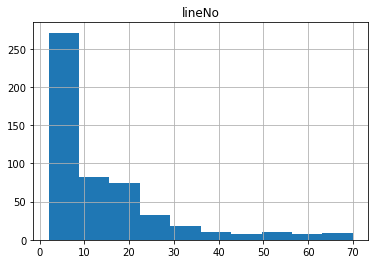

In [42]:
signatures[signatures.nlines-signatures.nBlanks < 75].hist(column="lineNo")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DAA8F42548>,
      dtype=object)

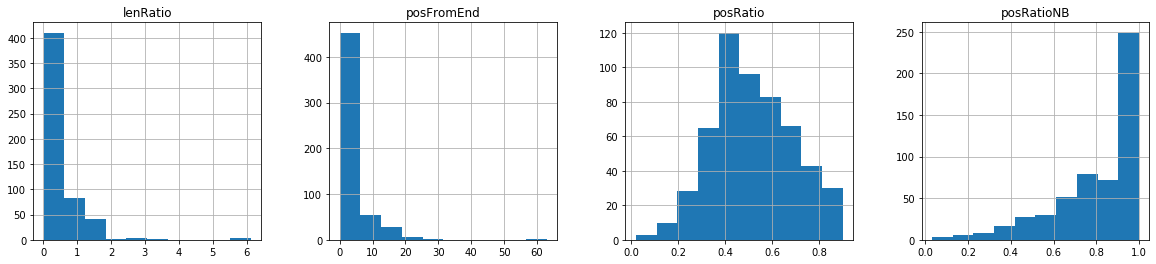

In [43]:
signatures.loc[:, ("posRatio", "posRatioNB", "posFromEnd", "lenRatio")].hist(layout=(1,4), figsize=(20,4))

In [44]:
noentities = master[master.entity=="no_entity"]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DAA9281608>,
      dtype=object)

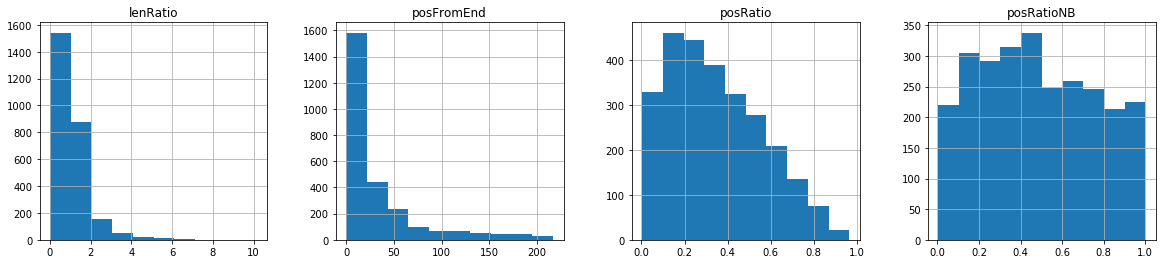

In [45]:
noentities.loc[:, ("posRatio", "posRatioNB", "posFromEnd", "lenRatio")].hist(layout=(1,4), figsize=(20,4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DAA925A548>,
      dtype=object)

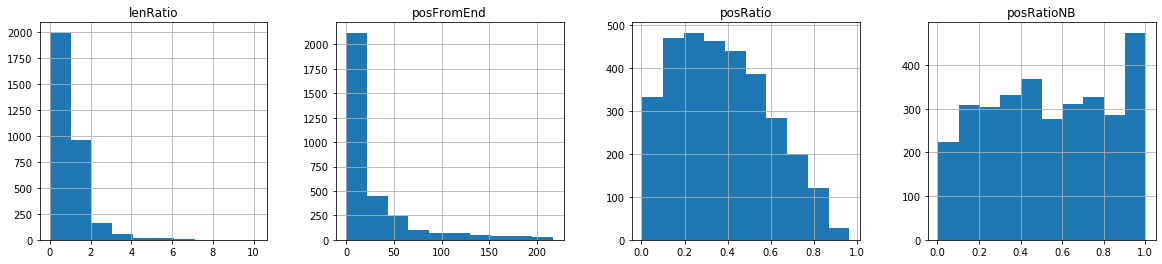

In [46]:
master.loc[:, ("posRatio", "posRatioNB", "posFromEnd", "lenRatio")].hist(layout=(1,4), figsize=(20,4))

In [47]:
signatures.len.describe()

count    544.000000
mean      32.169118
std       79.674735
min        2.000000
25%        7.000000
50%       15.000000
75%       28.000000
max      818.000000
Name: len, dtype: float64

In [48]:
noentities.len.describe()

count    2661.000000
mean       71.807591
std        86.053755
min         1.000000
25%        24.000000
50%        51.000000
75%        74.000000
max       698.000000
Name: len, dtype: float64

# Features

In [49]:
print(f"There are {sum(signatures.email)} email matches out of {len(signatures.index)} signature lines.")
print(f"There are {sum(signatures.phone)} phone matches out of {len(signatures.index)} signature lines.")
print(f"There are {sum(signatures.name)} name matches out of {len(signatures.index)} signature lines.") # Too low?

There are 27 email matches out of 544 signature lines.
There are 98 phone matches out of 544 signature lines.
There are 4 name matches out of 544 signature lines.


In [50]:
cross_tables = list()
cross_tbl_labels = list()
for column in master.columns:
    if is_binary(master[column]) and column != "entity":
        cross_tables.append(pd.crosstab(master.entity, master[column], margins=True))
        cross_tbl_labels.append(column)

In [51]:
display_side_by_side(cross_tables, cross_tbl_labels)

email,0,1,All
entity,,,
no_entity,2178,483,2661
signature,517,27,544
All,2695,510,3205
url,0,1,All
entity,,,
no_entity,1974,687,2661
signature,503,41,544
All,2477,728,3205
phone,0,1,All


In [52]:
def pvalue_to_star(pval):
    if pval > 0.05: return "ns"
    if pval <= 0.001: return "***"  
    if pval <= 0.01: return "**"
    if pval <= 0.05: return "*"

In [55]:
from scipy.stats import fisher_exact, chi2_contingency

In [56]:
chi_tests = list()
print("=== Chi Square Test ===")
for i, table in enumerate(cross_tables):    
    chi2, p, dof, expected = chi2_contingency(table)
    chi_tests.append({
        "feature": cross_tbl_labels[i],
        "p_value": p,
        "significance": pvalue_to_star(p)
    })
chi_tests_df = pd.DataFrame(chi_tests)
chi_tests_df.round(5)

=== Chi Square Test ===


,feature,p_value,significance
0,email,0.00000,***
1,url,0.00000,***
2,phone,0.98736,ns
3,sigdelimiter,0.95220,ns
4,special,0.00003,***
5,words,0.00000,***
6,name,0.97140,ns
7,endquote,0.93873,ns
8,tabs1,0.00000,***
9,tabs2,0.15812,ns


In [62]:
fisher_tests = list()
print("=== Fisher's Exact Test (only for no_entity vs signature) ===")
for i, table in enumerate(cross_tables):
    odds_ratio, p = fisher_exact(table.loc[("no_entity", "signature"),[0,1]])
    fisher_tests.append({
        "feature": cross_tbl_labels[i],
        "p_value": p,
        "significance": pvalue_to_star(p)
    })
fisher_tests_df = pd.DataFrame(fisher_tests)
fisher_tests_df.round(5)

=== Fisher's Exact Test (only for no_entity vs signature) ===


,feature,p_value,significance
0,email,0.00000,***
1,url,0.00000,***
2,phone,0.57442,ns
3,sigdelimiter,0.42836,ns
4,special,0.00001,***
5,words,0.00000,***
6,name,0.51248,ns
7,endquote,0.70905,ns
8,tabs1,0.00000,***
9,tabs2,0.00378,**


In [63]:
chi_tests_df[chi_tests_df.p_value < 0.05]

,feature,p_value,significance
0,email,5.421816e-12,***
1,url,9.400028e-18,***
4,special,2.719311e-05,***
5,words,4.827148e-21,***
8,tabs1,2.811480e-26,***
13,punct90,3.851155e-02,*
15,startpunct,1.347471e-02,*
17,alphanum90,9.372853e-84,***
20,title,9.891959e-83,***
21,last,2.244591e-86,***


In [64]:
fisher_tests_df[fisher_tests_df.p_value < 0.05]

,feature,p_value,significance
0,email,2.846548e-17,***
1,url,4.208346e-24,***
4,special,5.970499e-06,***
5,words,9.210895e-18,***
8,tabs1,1.492111e-42,***
9,tabs2,3.782061e-03,**
11,punct20,2.063532e-03,**
13,punct90,3.410669e-03,**
14,reply,6.184248e-03,**
15,startpunct,2.670145e-04,***


In [65]:
cross_tables = list()
cross_tbl_labels = list()
for column in master.columns:
    if is_binary(master[column]) and column != "entity":
        cross_tables.append(pd.crosstab(master.entity, master[column]).apply(lambda r: round((r/r.sum())*100, 2), axis=1))
        cross_tbl_labels.append(column)
display_side_by_side(cross_tables, cross_tbl_labels)

email,0,1
entity,,
no_entity,81.85,18.15
signature,95.04,4.96
url,0,1
entity,,
no_entity,74.18,25.82
signature,92.46,7.54
phone,0,1
entity,,
no_entity,83.01,16.99


In [66]:
master.loc[master.line.str.contains("@") & (master.email == 0), ("line", "email")]

,line,email
507,"CC: Bowen Jr., Raymond <Raymond.Bowen@ENRON.co...",0
690,Paulsen@WAPA.GOV,0
692,">>> ""Gang, Lisa"" <Lisa.Gang@ENRON.com> 06/06/0...",0
701,Paulsen@WAPA.GOV,0
801,Paulsen@WAPA.GOV,0
1259,Greg Whalley has requested a Trader's Meeting ...,0
1504,"Outage Commences: November 9, 2001 @ 8:00pm CST",0
1505,"Outage Ends: November 12, 2001 @ 2:00am CST",0
1811,Call Ed Baughman @ 713-853-6351 with any issues,0
2038,@ x3-5614.,0


In [67]:
master.to_csv("master.csv")
master.to_pickle("master.pkl")